In [2]:
import torch
from torch_geometric.data import Data
import pandas as pd
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.nn import MSELoss
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../../Datasets/Lynx_Hare/data.csv', usecols=['DATE', 'HARE', 'LYNX'])
print(df)

scaler = StandardScaler()
df[['HARE', 'LYNX']] = scaler.fit_transform(df[['HARE', 'LYNX']])

# Create lagged features for one-step ahead prediction
df['HARE_lag1'] = df['HARE'].shift(1)
df['LYNX_lag1'] = df['LYNX'].shift(1)

df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['HARE_lag1', 'LYNX_lag1']].values  # previous time step's data as input
y = df[['HARE', 'LYNX']].values  
print(df)

    DATE   HARE   LYNX
0   1845  19.58  30.09
1   1846  19.60  45.15
2   1847  19.61  49.15
3   1848  11.99  39.52
4   1849  28.04  21.23
..   ...    ...    ...
86  1931  19.52   8.31
87  1932  82.11  16.01
88  1933  89.76  24.82
89  1934  81.66  29.70
90  1935  15.76  35.40

[91 rows x 3 columns]
    DATE      HARE      LYNX  HARE_lag1  LYNX_lag1
1   1846 -0.713379  0.896212  -0.713932   0.093463
2   1847 -0.713103  1.109426  -0.713379   0.896212
3   1848 -0.923746  0.596114  -0.713103   1.109426
4   1849 -0.480069 -0.378806  -0.923746   0.596114
5   1850  0.348128 -1.061622  -0.480069  -0.378806
..   ...       ...       ...        ...        ...
86  1931 -0.715591 -1.067486  -1.138258  -1.138379
87  1932  1.014610 -0.657049  -0.715591  -1.067486
88  1933  1.226082 -0.187446   1.014610  -0.657049
89  1934  1.002171  0.072674   1.226082  -0.187446
90  1935 -0.819530  0.376504   1.002171   0.072674

[90 rows x 5 columns]


In [4]:
# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

In [5]:
edge_index = torch.tensor([[0], [1]], dtype=torch.long)  # Lynx -> Hare

data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

In [6]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(2, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [22]:
model = GNN()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()

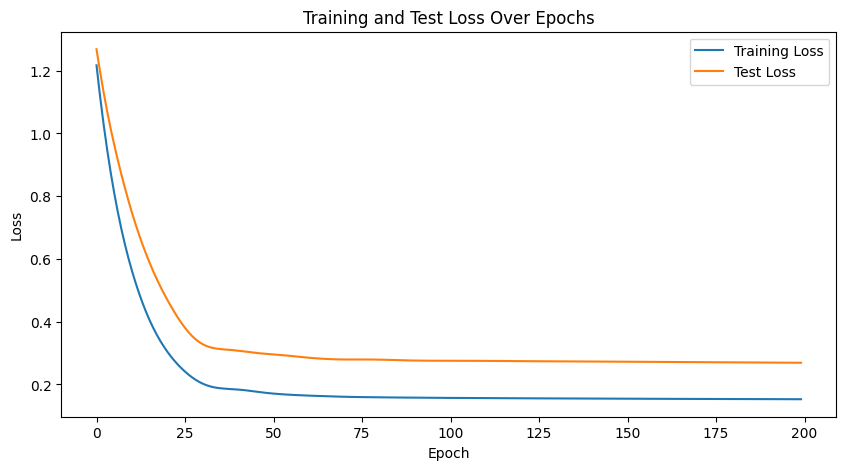

Final Test MSE: 0.26919010281562805


In [23]:
train_losses = []
test_losses = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')

In [24]:
df = pd.read_csv('../../Datasets/study_373/top_5_373_linear.csv', usecols=['46670', '46982', '46504', '46571', '46888'])
"""
46670  [Nyctereutes procyonoides]     Common Raccoon Dog      -> Rodents, Japanese Hare
46982  [Sus scrofa]				      Wild Boar               -> Rodents, Japanese Hare
46504  [Lepus brachyurus]			  Japanese Hare
46571  [Meles anakuma]			      Japanese Badger         -> Rodents
46888  [Rodentia]
"""

scaler = StandardScaler()
df[['46670', '46982', '46504', '46571', '46888']] = scaler.fit_transform(df[['46670', '46982', '46504', '46571', '46888']])

for col in ['46670', '46982', '46504', '46571', '46888']:
    df[f'{col}_lag1'] = df[col].shift(1)
df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['46670_lag1', '46982_lag1', '46504_lag1', '46571_lag1', '46888_lag1']].values  # previous time step's data as input
y = df[['46670', '46982', '46504', '46571', '46888']].values  
print(df)

         46670     46982     46504     46571     46888  46670_lag1  \
1    -1.083046 -0.783220 -0.800782 -0.792277 -0.025176   -1.083046   
2    -1.083046 -0.775406 -0.800782 -0.792277 -0.025176   -1.083046   
3    -1.083046 -0.767592 -0.800782 -0.792277 -0.025176   -1.083046   
4    -1.083046 -0.759779 -0.800782 -0.792277 -0.025176   -1.083046   
5    -1.083046 -0.751965 -0.800782 -0.792277 -0.025176   -1.083046   
...        ...       ...       ...       ...       ...         ...   
1611 -0.749483  0.076293 -0.800782 -0.792277 -0.025176   -0.725657   
1612 -0.773309  0.216940 -0.800782 -0.792277 -0.025176   -0.749483   
1613 -0.797135  0.357588 -0.800782 -0.792277 -0.025176   -0.773309   
1614 -0.820961  0.498236 -0.800782 -0.792277 -0.025176   -0.797135   
1615 -0.820961 -1.048888 -0.800782 -0.792277 -0.732738   -0.820961   

      46982_lag1  46504_lag1  46571_lag1  46888_lag1  
1      -0.791034   -0.800782   -0.792277   -0.025176  
2      -0.783220   -0.800782   -0.792277   -0.025

In [25]:
# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

In [26]:
edge_index = torch.tensor([
    [0, 0, 3, 3, 4],  # Predators: 46670 (Index 0), 46982 (Index 3), 46571 (Index 4)
    [1, 2, 1, 2, 1]   # Prey: 46888 (Index 1), 46504 (Index 2)
], dtype=torch.long)
data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

In [13]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(5, 16)
        self.conv2 = GCNConv(16, 5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [27]:
model = GNN()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()


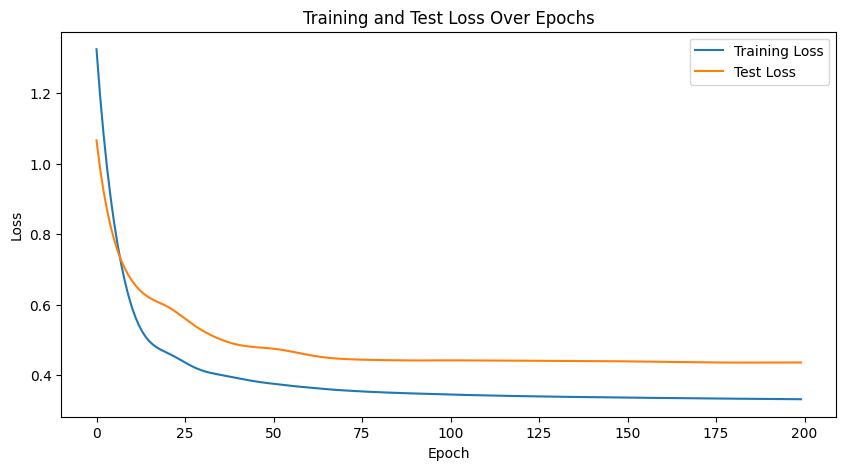

Final Test MSE: 0.43550288677215576


In [28]:
train_losses = []
test_losses = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')

In [29]:
df = pd.read_csv('../../Datasets/study_213/top_5_213_linear.csv', usecols=['7058', '8572', '39601', '8901', '7730'])
"""
7058 ['Merluccius bilinearis']  Silver hake             -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
8572 ['Squalus acanthias']      Spiny dogfish           -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
39601 ['Doryteuthis pealeii']   Longfin inshore squid   -> Silver hake, Longfin inshore squid
8901 ['Urophycis chuss']        Red hake                -> Silver hake, Longfin inshore squid, Red hake, American butterfish
7730 ['Peprilus triacanthus']   American butterfish     -> Longfin inshore squid
"""

scaler = StandardScaler()
df[['7058', '8572', '39601', '8901', '7730']] = scaler.fit_transform(df[['7058', '8572', '39601', '8901', '7730']])

for col in ['7058', '8572', '39601', '8901', '7730']:
    df[f'{col}_lag1'] = df[col].shift(1)
df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['7058_lag1', '8572_lag1', '39601_lag1', '8901_lag1', '7730_lag1']].values  # previous time step's data as input
y = df[['7058', '8572', '39601', '8901', '7730']].values  
print(df)

           7058      8572     39601      8901      7730  7058_lag1  8572_lag1  \
1      1.378244 -0.152011 -0.594670  0.234294 -0.421251   1.432539  -0.138382   
2      1.323949 -0.165639 -0.594698  0.222243 -0.421267   1.378244  -0.152011   
3      1.269654 -0.179268 -0.594725  0.210193 -0.421283   1.323949  -0.165639   
4      1.215359 -0.192896 -0.594753  0.198142 -0.421300   1.269654  -0.179268   
5      1.161064 -0.206524 -0.594781  0.186092 -0.421316   1.215359  -0.192896   
...         ...       ...       ...       ...       ...        ...        ...   
16427  0.401527 -0.088689 -0.589990  0.349224 -0.421659  -0.172691  -0.279902   
16428  0.190551 -0.214274 -0.550712  0.132943 -0.420279   0.401527  -0.088689   
16429 -0.020426 -0.339858 -0.511434 -0.083338 -0.418899   0.190551  -0.214274   
16430 -0.231403 -0.465443 -0.472156 -0.299620 -0.417519  -0.020426  -0.339858   
16431 -0.442380 -0.591028 -0.432878 -0.515901 -0.416139  -0.231403  -0.465443   

       39601_lag1  8901_lag

In [30]:
# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

In [31]:
edge_index = torch.tensor([
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4],  
    [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 2, 0, 2, 3, 4, 2]   
], dtype=torch.long)
data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

In [32]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(5, 16)
        self.conv2 = GCNConv(16, 5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [33]:
model = GNN()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()

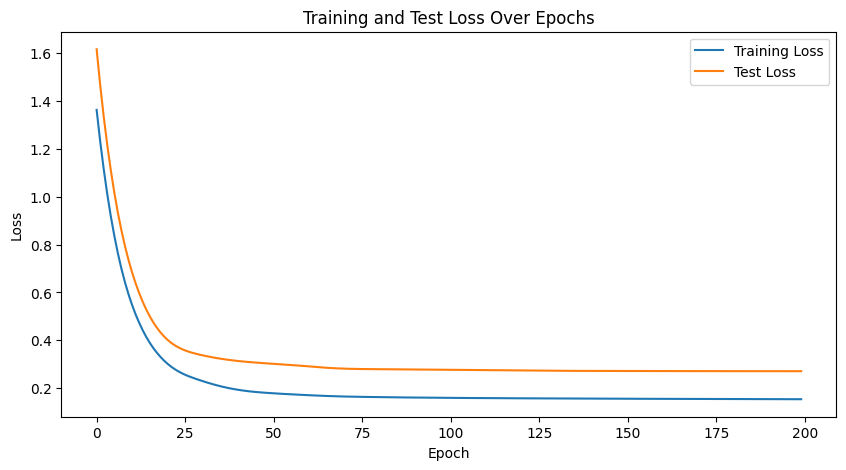

Final Test MSE: 0.27081289887428284


In [34]:
train_losses = []
test_losses = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')